In [111]:
# Need to install gluoncv and mxnet

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
from gluoncv import data, utils
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [189]:
coco=COCO('../../dataset/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [181]:
# Open the validation dataset
val_dataset = data.COCODetection('../../dataset',splits=['instances_val2017'])
print('Num of validation images:', len(val_dataset))
print(type(val_dataset))

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
Num of validation images: 4952
<class 'gluoncv.data.mscoco.detection.COCODetection'>


In [178]:
def resize_bboxes(bounding_boxes, height, width):
    """
    Resizes bounding boxes to the adjusted 256x256 input image.
    @param bounding_boxes - np array: contains arrays of bounding boxes as elemenest
    @param height - int: height of the image containing the bounding box
    @param width - int: width of the image containing the bounding box
    Returns adjusted bounding box.
    """
    x_scale = 256 / width
    y_scale = 256 / height
    

    for i in range(bounding_boxes.shape[0]):
        bounding_box = bounding_boxes[i]
        bounding_box[0] *= x_scale
        bounding_box[2] *= x_scale

        bounding_box[1] *= y_scale
        bounding_box[3] *= y_scale
    
    return bounding_boxes

In [182]:
# Resize images
dsize = (256, 256)
val_resized = [(cv2.resize(image.asnumpy(), dsize), label) for image, label in val_dataset]


In [183]:
# Sanity check
def change_labels(val_dataset, val_resized):
    for i in range(len(val_resized)):
        image, label = val_resized[i]
        original_image, _ = val_dataset[i]
        bounding_boxes = label[:, :4]
        label[:, :4] = resize_bboxes(bounding_boxes, original_image.shape[0], original_image.shape[1])
        val_resized[i] = (image, label)

    return val_resized

val_resized = change_labels(val_dataset, val_resized)


In [129]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
animal electronic sports outdoor food kitchen accessory vehicle appliance furniture indoor person


(3, 5)
Image size (height, width, RGB): (256, 256, 3)
Num of objects: 3
Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):
 [[ 74.84552693  74.62       244.59091335 239.528     ]
 [ 16.38519906  39.12        95.10969555 204.4       ]
 [  9.52655738   9.1        208.1393911  113.876     ]]
Class IDs (num_boxes, ):
 [[22.]
 [22.]
 [22.]]
(3, 1)


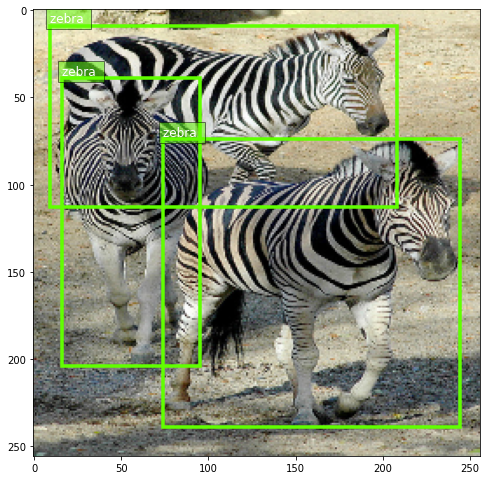

In [187]:
# Sanity check: check to see if bounding box locations load
val_image, val_label = val_resized[np.random.randint(1, 4000)]  # Display resized image
bounding_boxes = val_label[:, :4]
class_ids = val_label[:, 4:5]
print(val_label.shape)
print('Image size (height, width, RGB):', val_image.shape)
print('Num of objects:', len(bounding_boxes))
print('Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):\n',
      bounding_boxes)
print('Class IDs (num_boxes, ):\n', class_ids)
print(class_ids.shape)

utils.viz.plot_bbox(val_image, bounding_boxes, scores=None, labels=class_ids, class_names=val_dataset.classes)
plt.show()

In [190]:
import os
import json

classes = ["oven", "bicycle", "knife", "bird", "airplane", "bat", "vase", "umbrella", "toaster", "book", "sandwich", "cake", "apple", "dog", "donut", "train", "suitcase", "chair", "toothbrush", "couch", "cat", "elephant", "cup", "toilet", "bench", "sheep", "bus", "keyboard", "zebra", "baseball", "banana", "table", "mouse", "giraffe", "fork", "laptop", "truck", "pizza", "bed", "skateboard", "car", "horse", "bear", "spoon", "microwave", "scissors", "broccoli", "sink", "clock", "cow", "carrot", "backpack"]

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]

def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    @param bb1 - array contaning first bounding box
    @param bb2 - array containing second bounding box
    
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

def bbox_loss(bounding_boxes, bbox):
    """
    @param bounding_boxes - list: contains list as elements, each specifying a bounding box
    @param bbox - dict: contains keys for one bounding box of Quick! Draw sketch (coordinates, id, etc.)

    Here, loss is IOU between two bounding boxes.

    Returns
        (1) The "loss" of the best match (the maximum is the best)
        (2) The index of the bounding box that best matches it
    """


    # Init
    best_iou = None
    best_match_idx = -1

    bbox_coords = bbox['bbox']  # Gets bounding box coordinates for the composite image
    for idx in range(len(bounding_boxes)):
        bounding_box = bounding_boxes[idx]
        iou = get_iou(bounding_box, bbox_coords)

        if best_iou == None or iou > best_iou:
            best_iou = iou
            best_match_idx = idx

    return best_iou, best_match_idx


def loss_one_image(bounding_boxes, class_ids, img, class_weight=1e6, bbox_weight=0.1):
    """
    Returns the loss in comparing composite image to one image in the COCO dataset
    @param bounding_boxes - list: contains lists as elements, each specifiying a bounding box 
    for an image
    @param class_ids - list
    @param img - dict: takes in a dictionary of image data
    @param class_weight - float: how much to weight bounding box discrepancy
    @param bbox_weight - float: how much to weight class discrepancy
    """
    annotations = img['annotations']  # List of bbox annotations
    loss = 0
    for bbox in annotations:
        loss_bbox, best_match_idx = bbox_loss(bounding_boxes, bbox) # For the best bbox, loss and best_match_idx
        class_id_best = int(class_ids[best_match_idx][0]) # Gets label for that box
        class_id_sketch = nms.index(classes[bbox['category_id']]) # Gets label for the class in COCO

        if class_id_best == class_id_sketch:
            loss_class = 1
        else:
            loss_class = 0

        loss += class_weight * loss_class + bbox_weight * loss_bbox

    return loss

def find_nearest_neighbor(dataset, img):
    best_loss = -1
    best_match = None
    for i in range(len(dataset)):
        val_image, val_label = dataset[i]  # Get image
        bounding_boxes = val_label[:, :4]
        class_ids = val_label[:, 4:5]
        loss = loss_one_image(bounding_boxes, class_ids, img)

        if best_loss == -1 or loss > best_loss:
            best_loss = loss
            best_match = val_image

    return best_match

In [191]:
# Test bounding box loss
test_image = {"file_name": "/home/phil/coco/PicIt/data/../dataset/composite/test/0000000.jpg", "height": 224, "width": 224, "image_id": 0, "annotations": [{"bbox": [107, 40, 147, 69], "bbox_mode": 0, "category_id": 33}, {"bbox": [154, 105, 206, 144], "bbox_mode": 0, "category_id": 41}, {"bbox": [7, 29, 69, 122], "bbox_mode": 0, "category_id": 23}, {"bbox": [13, 157, 40, 190], "bbox_mode": 0, "category_id": 0}, {"bbox": [173, 142, 206, 176], "bbox_mode": 0, "category_id": 46}, {"bbox": [86, 175, 120, 196], "bbox_mode": 0, "category_id": 25}]}

best_match = find_nearest_neighbor(val_resized, test_image)

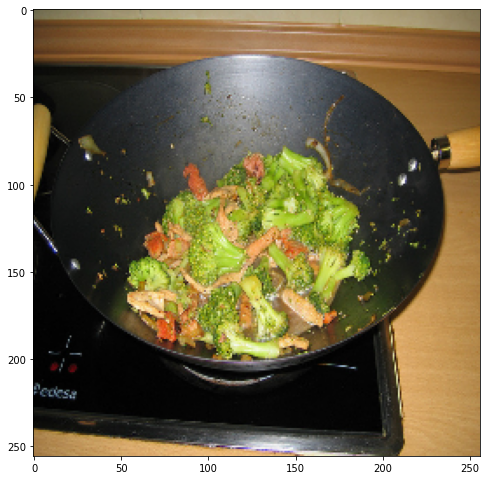

In [193]:
utils.viz.plot_image(best_match)
plt.show()

In [29]:
for box in test_image['annotations']:
    print(classes[box['category_id']])

giraffe
horse
toilet
oven
broccoli
sheep


In [86]:
catIds = coco.getCatIds(catNms=['broccoli'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds );


[56]


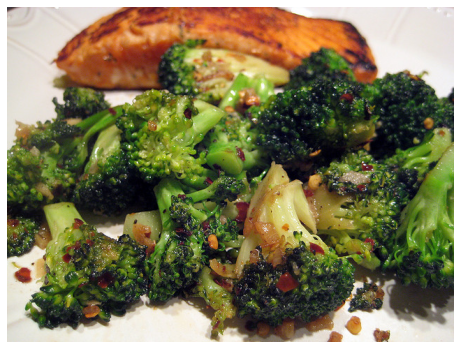

In [110]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [63]:
nms[21]

'bear'